In [6]:
import torch
import numpy as np

In [7]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [8]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0

batch_size = 20

valid_size = 0.2

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])



In [41]:
trainset = datasets.MNIST('mnist_train', train=True, download=True, transform=transform)

testset = datasets.MNIST('mnist_test', train=False, download=True, transform=transform)

num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))

train_idx, valid_idx = indices[split:], indices[:split];

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=num_workers)

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

<ipython-input-10-731dd270b2c2>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


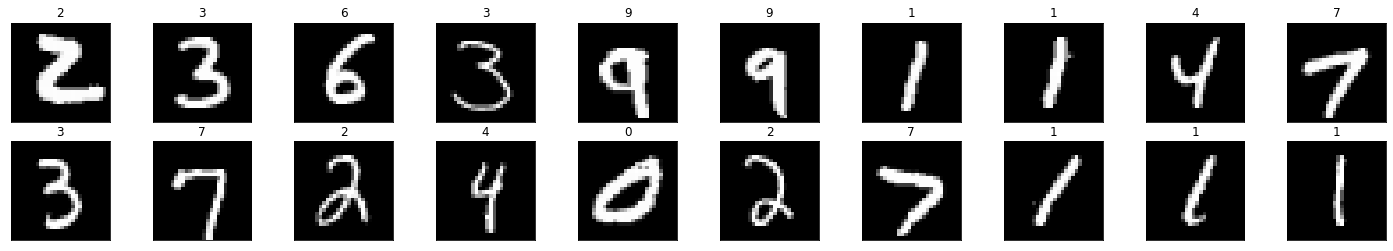

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

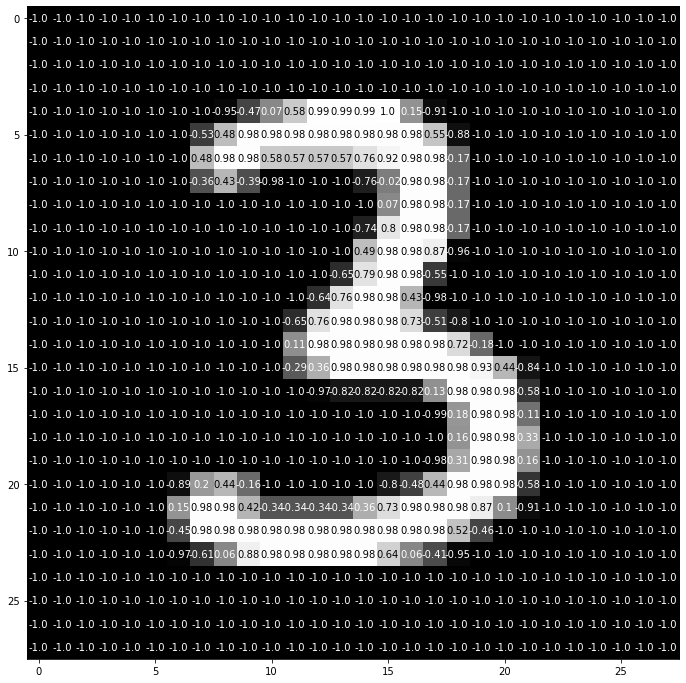

In [11]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [33]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layer 1 
        # input shape: batch size, 28, 28, 1
        # output shape: batch size, 28, 28, 16
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)

        # Convolutional layer 2
        # input shape: batch size, 14, 14, 16
        # output shape: batch size, 14, 14, 32
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)


        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 10)

        self.dropout = nn.Dropout(0.2)


    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)

        x = self.dropout(x)

        x = F.relu(self.fc1(x))

        x = self.dropout(x)

        x = self.fc2(x)

        return x
    
model = Net()
print(model)


Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [36]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.003)

In [37]:
n_epochs = 30

valid_loss_min = np.Inf

model.to('cuda')

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0

    model.train()

    for data, target in train_loader:
        data, target = data.to('cuda'), target.to('cuda')
        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output, target)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()*data.size(0)

    model.eval()
    for data, target in valid_loader:
        
        data, target = data.to('cuda'), target.to('cuda')
        output = model(data)

        loss = criterion(output, target)

        valid_loss += loss.item()*data.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_mnist.pt')
        valid_loss_min = valid_loss
    


Epoch: 1 	Training Loss: 0.128137 	Validation Loss: 0.018370
Validation loss decreased (inf --> 0.018370).  Saving model ...
Epoch: 2 	Training Loss: 0.118892 	Validation Loss: 0.020165
Epoch: 3 	Training Loss: 0.110790 	Validation Loss: 0.016631
Validation loss decreased (0.018370 --> 0.016631).  Saving model ...
Epoch: 4 	Training Loss: 0.105890 	Validation Loss: 0.016124
Validation loss decreased (0.016631 --> 0.016124).  Saving model ...
Epoch: 5 	Training Loss: 0.100209 	Validation Loss: 0.017407
Epoch: 6 	Training Loss: 0.102599 	Validation Loss: 0.017710
Epoch: 7 	Training Loss: 0.097961 	Validation Loss: 0.015406
Validation loss decreased (0.016124 --> 0.015406).  Saving model ...
Epoch: 8 	Training Loss: 0.096082 	Validation Loss: 0.015265
Validation loss decreased (0.015406 --> 0.015265).  Saving model ...
Epoch: 9 	Training Loss: 0.097330 	Validation Loss: 0.014678
Validation loss decreased (0.015265 --> 0.014678).  Saving model ...
Epoch: 10 	Training Loss: 0.096899 	Valida

In [38]:
model.load_state_dict(torch.load('model_mnist.pt'))

<All keys matched successfully>

In [42]:
test_loss = 0.0

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    data, target = data.to('cuda'), target.to('cuda')

    output = model(data)

    loss = criterion(output, target)

    test_loss += loss.item() * data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())

    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
    

Test Loss: 0.066813

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 98% (1123/1135)
Test Accuracy of     2: 98% (1016/1032)
Test Accuracy of     3: 98% (994/1010)
Test Accuracy of     4: 97% (961/982)
Test Accuracy of     5: 97% (870/892)
Test Accuracy of     6: 97% (930/958)
Test Accuracy of     7: 97% (1005/1028)
Test Accuracy of     8: 97% (950/974)
Test Accuracy of     9: 96% (976/1009)

Test Accuracy (Overall): 97% (9797/10000)


In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

<ipython-input-44-2181f8df30a5>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


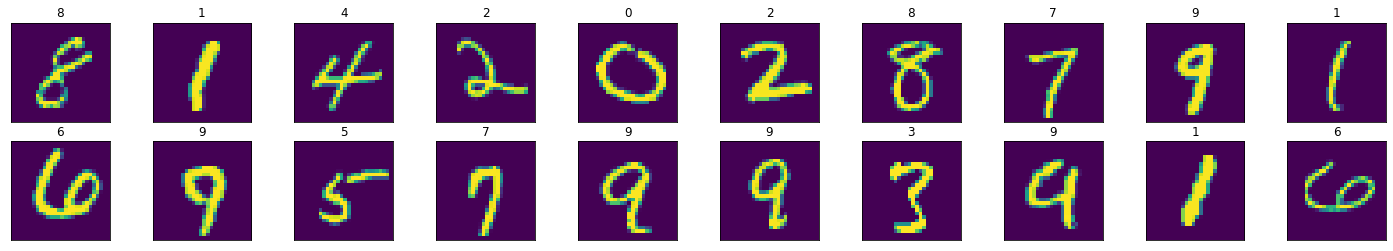

In [44]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])